In [1]:
%pylab inline
import math
import polyline
import itertools
import pandas as pd
import pylab as plt
from glob import glob
import seaborn as sns
from itertools import cycle
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans,AgglomerativeClustering
# --------------------------------------------------------
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

def get_rawdf(test):
    rawdf = pd.read_pickle('../data/{0:s}_latest.pdpkl'.format(test))
    return rawdf

prj = 0
tests = ['inside','outin','bigpar']
N_CLUSTERS = [8,10,12][prj] # 10 for test 0
BOUNDARIES = [(250000,270000,6210000,6227000),
              (245000,275000,6205000,6235000),
              (245000,275500,6200000,6235000)][prj]
df = get_rawdf(tests[prj])
TITLE = tests[prj]

!mkdir plots/

Populating the interactive namespace from numpy and matplotlib
mkdir: cannot create directory ‘plots/’: File exists


In [2]:
sns.set_context('talk')
sns.set_style('whitegrid')

In [3]:
df.groupby(('mode','kind')).count()

departure  distance  duration  haversine_distance      p1  \
mode      kind                                                              
bicycling full      21694     21694     21694               21694   21694   
          step     145568    145568    145568              145568  145568   
driving   full      21690     21690     21690               21690   21690   
          step     141267    141267    141267              141267  141267   
transit   full      21694     21694     21694               21694   21694   
          step      24318     24318     24318               24318   24318   
walking   step      45029     45029     45029               45029   45029   

                    p2  polyline  walk_distance  duration[m]  distance[km]  \
mode      kind                                                               
bicycling full   21694     21694              0        21694         21694   
          step  145568         0              0       145568        145568   
driving   full   21690     21690              0        21690         21690   
          step  141267         0              0       141267        141267   
transit   full   21694     21694              0        21694         21694   
          step   24318         0              0        24318         24318   
walking   step   45029         0              0        45029         45029   

                coupled  bicycling_faster_driving    same  
mode      kind                                             
bicycling full    21694                     21694   21694  
          step   145568                    145568  145568  
driving   full    21690                     21690   21690  
          step   141267                    141267  141267  
transit   full    21694                     21694   21694  
          step    24318                     24318   24318  
walking   step    45029                     45029   45029

In [4]:
df.head()

,departure,distance,duration,haversine_distance,kind,mode,p1,p2,polyline,walk_distance,duration[m],distance[km],coupled,bicycling_faster_driving,same
0,2017-05-15 08:00:00,4498.0,1630.0,3112.563236,full,transit,"[48.8471802778, 2.34505473368]","[48.8654258802, 2.31279017402]",kmciHg_iMKf@g@~EnB|@WlBe@jDo@dF@@DDRAzAt@d@\R[...,None,27.166667,3.112563,0,-1,1
1,2017-05-15 08:00:00,551.0,454.0,400.680536,step,walking,"[48.8471015, 2.3449996]","[48.845743, 2.339928]",None,None,7.566667,0.400681,0,-1,1
2,2017-05-15 08:00:00,974.0,180.0,955.261713,step,transit,"[48.845743, 2.339928]","[48.853336, 2.346035]",None,None,3.000000,0.955262,0,-1,1
3,2017-05-15 08:00:00,0.0,0.0,0.000000,step,walking,"[48.853336, 2.346035]","[48.853336, 2.346035]",None,None,0.000000,0.000000,0,-1,1
4,2017-05-15 08:00:00,2641.0,300.0,2579.639640,step,transit,"[48.853336, 2.346035]","[48.862902, 2.313911]",None,None,5.000000,2.579640,0,-1,1


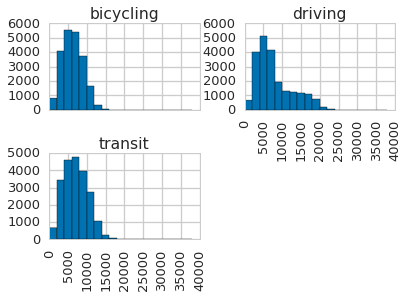

In [5]:
df[df.kind=='full'].hist(column='distance',by='mode',grid=False,sharex=1,bins=np.arange(0,40000,2000));

In [6]:
# drange = df[(df.haversine_distance>6000) ]

In [7]:
# drange.hist(column='distance',by='mode',sharex=True,bins=np.arange(0,40000,2000));

In [8]:
from scipy.optimize import curve_fit
def poly(x,*coeffs):
    out = 0
    for i,c in enumerate(coeffs):
        out += x**i*c
    return out

def fitit(x,y,func,p0):
    popt,pcov = curve_fit(func,p0=p0,xdata=x,ydata=y)
    ix = np.sort(x)
    return ix,poly(ix,*popt)

def wvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].var()

def mvar(x,y,xm,xM):
    return y[(x>xm) & (x<xM)].mean()

def wvarlist(x,y,dx,win):
    vy = []
    my = []
    vx = []
    for x0 in np.arange(x.min(),x.max(),dx):
        xm=x0-win
        xM=x0+win
        my.append(mvar(x,y,xm,xM))
        vy.append(wvar(x,y,xm,xM))
        vx.append(x0)
    return np.asarray(vx),np.asarray(my),np.asarray(vy)
        

In [9]:
import itertools
def allclose(x,y,eps=1e-15):
    z = []
    
    for i,j in zip(x,y):
        z.append(i-j)
    try:
        for j in z:
            if abs(j)>eps:
                return False
    except TypeError:
        for j in itertools.chain.from_iterable(z):
            if abs(j)>eps:
                return False
    except:
        if abs(z)>eps: return False
    return True

In [10]:
def get_coupled_trips(mode1,mode2,maxdist=False):
    if not maxdist:
        irows = df[(df.kind=='full') ].iterrows()
    else:
        irows = df[(df.kind=='full') & (df.haversine_distance<maxdist)].iterrows()
        
    bicycling = []
    driving   = []
    for ix,row in tqdm(irows):

        rowa = row

        if rowa['mode']!=mode1:
            continue

        ix,rowb = irows.next()

        while rowb['mode'] != mode2:
            try:
                ix,rowb = irows.next()
            except StopIteration:
                break

        if allclose(rowb.p1,rowa.p1) and allclose(rowb.p2,rowa.p2):
            bicycling.append(rowa)
            driving.append(rowb)
        else:
            continue
    return pd.DataFrame(bicycling),pd.DataFrame(driving)

In [11]:
from scipy.interpolate import interp1d
def sample_const_ds(X,Y,dx=50):
    ds = [0,]
    ds.extend((np.diff(X)**2+np.diff(Y)**2)**.5)
    L = np.cumsum(ds)
    fx = interp1d(L,X)
    fy = interp1d(L,Y)
    Lnew = np.arange(0,L.max(),dx)
    Xnew = fx(Lnew)
    Ynew = fy(Lnew)
    return Xnew,Ynew

def sample_const_N(X,Y,N=50):
    ds = [0,]
    ds.extend((np.diff(X)**2+np.diff(Y)**2)**.5)
    L = np.cumsum(ds)
    dx = L.max()*1./N
    fx = interp1d(L,X)
    fy = interp1d(L,Y)
    Lnew = np.arange(0,L.max(),dx)
    Xnew = fx(Lnew)
    Ynew = fy(Lnew)
    return Xnew,Ynew

In [12]:
import math
## http://wiki.openstreetmap.org/wiki/Mercator#Python_implementation
def _merc_x(lon):
    r_major=6378137.000
    return r_major*math.radians(lon)

def _merc_y(lat):
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

merc_x=lambda lon:np.asarray(map(_merc_x,lon))
merc_y=lambda lat:np.asarray(map(_merc_y,lat))

In [13]:
def get_coupled_trips_relative_speed(mode1,mode2,df):    
    """ compatibility function to get this stuff from the data"""
    
    # selection receipt
    cpd = df[df.coupled>0]
    row_mode1 = cpd[cpd['mode']==mode1]
    row_mode2 = cpd[cpd['mode']==mode2]
    return row_mode1,row_mode2,df

bicycling,driving,df=get_coupled_trips_relative_speed('bicycling','driving',df=df)
# idx_bike_slow = driving.bicycling_faster_driving==0
bike = bicycling[bicycling.bicycling_faster_driving==1]
car  = driving[driving.bicycling_faster_driving==0]

nobike = bicycling[bicycling.bicycling_faster_driving==0]
nocar  = driving[driving.bicycling_faster_driving==1]

In [14]:
from matplotlib.colors import LogNorm
np.insert(df.same.cumsum().values,0,0)

array([          0,           1,           2, ..., 12435071676,
       12435136754, 12435201832])

In [15]:
def makeit(idf,mode,title):
    figure()
    cc = 0
    X=[]
    Y=[]
    kind = df.kind=='full'
    for idx in tqdm(idf[idf['mode']==mode].same.unique()):
        same = df.same==idx
        full = df[same & kind]
        step = df[same & ~kind]
#         TD = full.duration.sum()
        TP = step.duration.cumsum().values
        TP = np.insert(TP,0,0)
        try:
            TD = TP.max()
        except ValueError:
            continue
        ETA_perc=((TD-TP)/TD) # Estimated Time to Arrival
#         TD = full.distance.sum()
        TP = step.distance.cumsum().values
        TP = np.insert(TP,0,0)
        try:
            TD = TP.max()
        except ValueError:
            continue
        EDA_perc=((TD-TP)/TD) # Estimated Distance to Arrival

        try:
            x,y=sample_const_ds(ETA_perc,EDA_perc,.005)
        except:
            continue

        X.extend(x)
        Y.extend(y)
        cc +=1
#         if cc>10000:break
    plt.hist2d(X,Y,bins=np.arange(0,1,.01),cmap=plt.cm.jet,norm=LogNorm())
    plt.xlabel('time')
    plt.ylabel('space')
    plt.title(title)

modes = ['driving','driving','bicycling','bicycling']
datas = [car,nocar,bike,nobike]
title = ['car is convenient','car is not convenient','bike is convenient','bike is not convenient']
# for d,m,t in zip(datas,modes, title):
#     makeit(d,m, t)

In [16]:
D = [] # delta time
S = [] # delta space
df['BikeMinusCarT']=np.nan
df['BikeMinusCarS']=np.nan

for j in tqdm(df.groupby('coupled')):
    if j[0]:
        
        data = j[1]
#         if  data.bicycling_faster_driving.values[0]: continue
        cD = data[data['mode']=='driving'].duration.values[0]
        cB = data[data['mode']=='bicycling'].duration.values[0]
        dT = cB-cD
        D.append(dT)
        df.loc[data.index,'BikeMinusCarT']=dT
        
        cD = data[data['mode']=='driving'].distance.values[0]
        cB = data[data['mode']=='bicycling'].distance.values[0]
        dT = cB-cD
        S.append(dT)
        df.loc[data.index,'BikeMinusCarS']=dT
        
# D=np.array(D)/60.
# S = np.array(S)/1000.

Widget Javascript not detected.  It may not be installed or enabled properly.


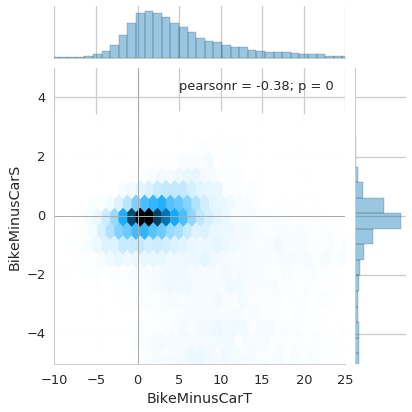

In [17]:
dk = df[df.kind=='full']
T = dk.BikeMinusCarT/60.
S = dk.BikeMinusCarS/1000.

g= sns.jointplot(T,S,xlim=(-10,25),ylim=(-5,5),kind='hex')
g.fig.axes[0].axvline(0,lw=1,color='#aaaaaa')
g.fig.axes[0].axhline(0,lw=1,color='#aaaaaa')
g.savefig('plots/{0:s}_DTDS.png'.format(TITLE),bbox_inches='tight')

In [18]:
def plot_streets(N,ax,df,**kwargs):
    count = 0
    for poly in tqdm(df.polyline,total=N):
        path = polyline.decode(poly)
        _X,_Y = map(None,*path)
        Y = merc_y(_Y)
        X = merc_x(_X)
        ax.plot(Y,X,**kwargs)
        count+=1
        if count>N:
            break

In [19]:
df['p1_lat']=df.p1.apply(lambda x:_merc_x(x[0]))
df['p1_lon']=df.p1.apply(lambda x:_merc_y(x[1]))
df['p2_lat']=df.p2.apply(lambda x:_merc_x(x[0]))
df['p2_lon']=df.p2.apply(lambda x:_merc_y(x[1]))

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


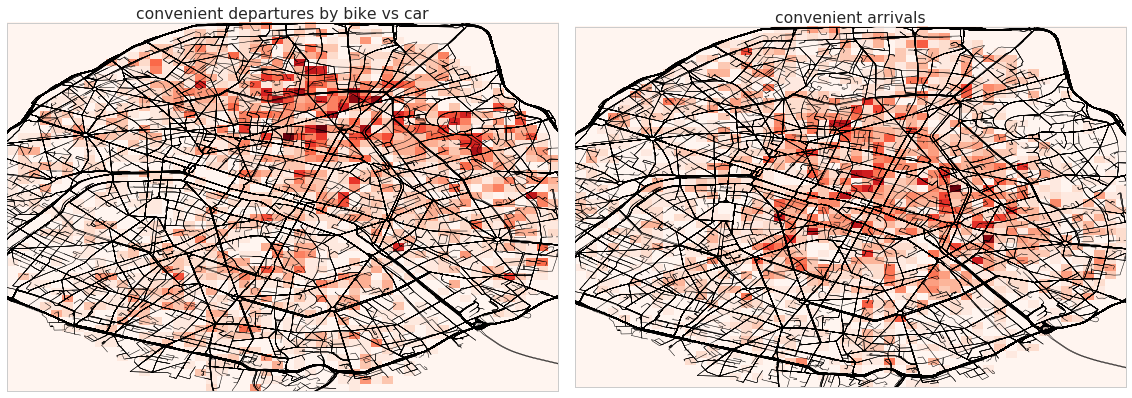

In [20]:
def make_hist(X,Y,bins,cmap,color,ax=None):
    if not ax:
        plt.figure()
        ax=plt.gca()
    ax.hist2d(X,Y,bins=bins,cmap=cmap);
    plot_streets(2000,ax,car,zorder=1000,lw=.5,color=color)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    
fig,(ax,bx)=plt.subplots(1,2,figsize=(16,10))
full = df[df.kind=='full']
bike = full[(full['mode']=='bicycling') & (full.bicycling_faster_driving==1)]
make_hist(bike.p1_lon,bike.p1_lat,50,plt.cm.Reds,'k',ax=ax)

full = df[df.kind=='full']
bike = full[(full['mode']=='bicycling') & (full.bicycling_faster_driving==1)]
make_hist(bike.p2_lon,bike.p2_lat,50,plt.cm.Reds,'k',ax=bx)

ax.set_title('convenient departures by bike vs car')
bx.set_title('convenient arrivals')
fig.tight_layout()
ax.set_aspect('equal')
bx.set_aspect('equal')
fig.savefig('../plots/{0:s}_p1_p2_hist.png'.format(TITLE),bbox_inches='tight')